# DATA20001 Deep Learning - Group Project
## Image project

**Due Thursday, May 20, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

## Load Dataset & do Data Augmentation

Using [this](https://github.com/mdbloice/Augmentor) library. Saves images to Output folder in same path. Read the [documentation](https://augmentor.readthedocs.io/)

## Get the data

In [ ]:
import Augmentor

p = Augmentor.Pipeline(train_path_images)

p.crop_random(1, 0.30, True) # crop with prob 1, max. 30%
p.flip_left_right(1) # flip with prob 1
p.flip_top_bottom(1) # flip with prob 1
#p.invert(1) # invert image with prob 1
p.random_erasing(1, 0.25) # erase 25% of image with prob 1
p.rotate_without_crop(1, 180, 180) # rotate image between -180 ° and 180° wtih no expanding or colorfilling
p.process()


In [33]:
import sys
import os
from os.path import join
from os.path import abspath
from os.path import split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import zipfile

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

root_dir = os.getcwd()
if root_dir not in sys.path:
    sys.path.append(root_dir)
    
train_path = 'train'

train_path_images = os.path.join(train_path, 'images')
train_path_annotations = os.path.join(train_path, 'annotations')

# check if we need to unzip data
try:
    os.listdir(train_path_images)
except OSError as e:
    data_folder_name = 'image-training-corpus+annotations'
    DATA_FOLDER_DIR = os.path.abspath(os.path.join(root_dir, data_folder_name))

    data_zip_name = 'dl2018-image-proj.zip'
    DATA_ZIP_DIR = os.path.abspath(os.path.join(DATA_FOLDER_DIR, data_zip_name))

    with zipfile.ZipFile(DATA_ZIP_DIR) as zip_f:
        zip_f.extractall(train_path)        


class CustomDataset(Dataset):
    def __init__(self, train_path_images, train_path_annotations):
        # store path to images to get images dynamically
        self.train_path_images = train_path_images
        self.length = len(os.listdir(train_path_images)) # num of images
        self.n_categories = len(os.listdir(train_path_annotations))+1
        self.categories = {} #{0: 'bird', 1:'baby', ...}

        self.annotations = {}
        for file_index, annotation_file in enumerate(os.listdir(train_path_annotations)):
            category, _ = annotation_file.split('.')
            self.categories[file_index] = category # match categories to files
            
            empty_label_vector = np.zeros(self.n_categories)

            with open(os.path.join(train_path_annotations, annotation_file)) as f:
                for line in f:
                    img_id = int(line.replace('\n', ''))
                    
                    if img_id not in self.annotations:
                        self.annotations[img_id] = np.zeros(self.n_categories)
                        
                    # set class in label
                    self.annotations[img_id][file_index] = 1

                      
        # fill 'other' for unlabeled images
        self.categories[self.n_categories-1] = 'other'
        one_hot_encoding_other = np.zeros(self.n_categories)
        one_hot_encoding_other[-1] = 1
        for i in range(1, self.length+1):
            if i not in self.annotations:
                self.annotations[i] = one_hot_encoding_other

        
        # class weights based on counts
        class_counts = sum(self.annotations.values())
        self.class_counts = class_counts
        # scaling
        #self.weights = torch.Tensor(list(map(lambda x: sum(class_counts)/x, class_counts)))
        self.weights = torch.Tensor(list(map(lambda x: 1/x, class_counts)))
        # standardizing
        self.weights = self.weights / max(self.weights)
        
        # take 0/1 imbalance into account
        labels_count = class_counts.sum()
        total_possible_labels = self.n_categories * self.length
        self.label_imbalance = torch.Tensor(np.array(total_possible_labels / labels_count))

        # Transformations
        self.center_crop = transforms.CenterCrop(100)
        self.horizantal_flip = transforms.RandomHorizontalFlip() # default is p=0.5 
        self.vertical_flip = transforms.RandomVerticalFlip() # default is p=0.5
        self.rotation = transforms.RandomRotation(degrees=(-90,90)) 
        # images are already normalized!!
        self.grayscale = transforms.Grayscale(num_output_channels=1)
        self.to_tensor = transforms.ToTensor()
        
    def __getitem__(self, index):
        index += 1 # image labels start with 1
        label = self.annotations[index]
        img = Image.open(os.path.join(self.train_path_images, 'im{}.jpg'.format(index))).convert('RGB')
        
        # When you call the transform for the second time it calls __call__() and applies the transform 
        img = self.center_crop(img)
        img = self.horizantal_flip(img)
        img = self.vertical_flip(img)
        # img is PIL Image
        #img = self.grayscale(img)
        
        # img to tensor
        img = self.to_tensor(img)

        return img, label

    def __len__(self):
        return len(self.annotations)

custom_dataset = CustomDataset(train_path_images, train_path_annotations)
print("done")


done


In [34]:
custom_dataset.weights

tensor([0.5491, 0.1589, 0.0304, 1.0000, 0.2121, 0.0868, 0.0148, 0.2639, 0.2978,
        0.7917, 0.0294, 0.0319, 0.1810, 0.1248, 0.0097])

In [35]:
def get_written_label(hot_encoded_label):
    labels = []
    for i, e in enumerate(hot_encoded_label):
        if e:
            labels.append(custom_dataset.categories[i])
    return ', '.join(labels)


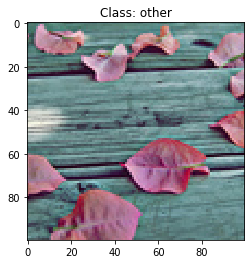

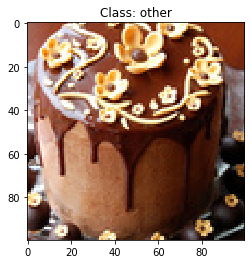

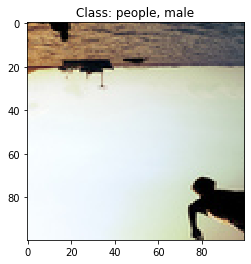

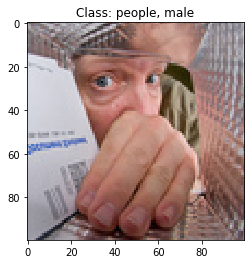

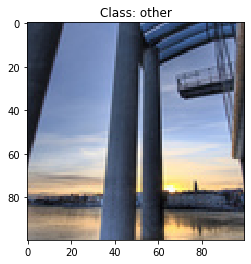

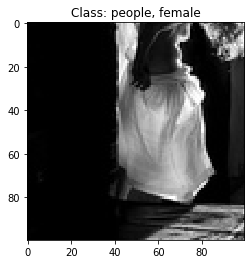

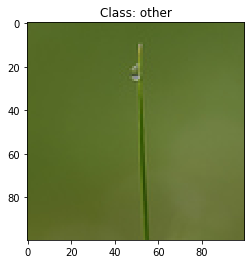

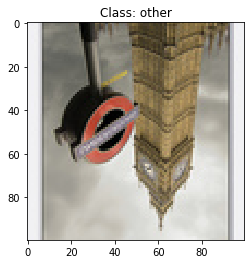

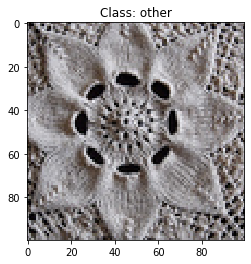

In [36]:
# print random images with labels

for i in range(1,11):
    # merge color dimensions
    image, label = custom_dataset.__getitem__(i)
    r, g, b = image
    image = np.dstack((r,g,b))
    plt.imshow(image)
    plt.title('Class: '+str(get_written_label(label)))
    plt.show()
    if i == n-1:
        break



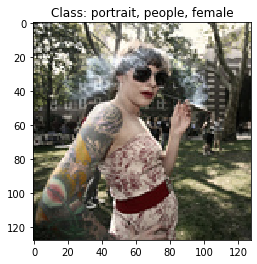

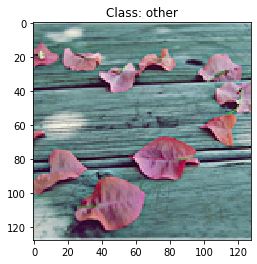

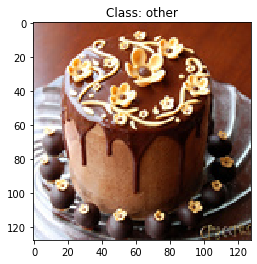

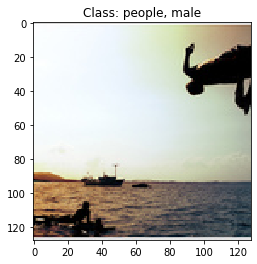

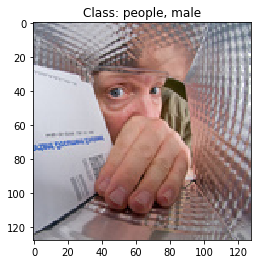

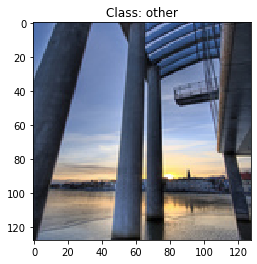

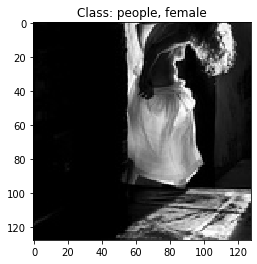

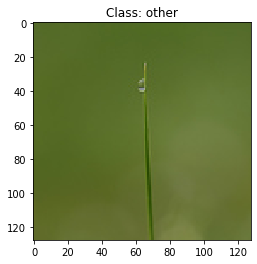

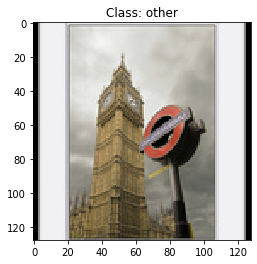

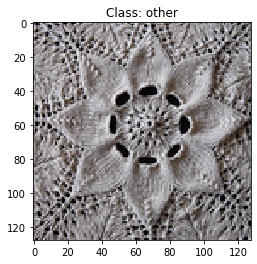

In [30]:
# print random images with labels
n = 10

for i, (image, label) in enumerate(custom_dataset):
    # merge color dimensions
    r, g, b = image
    image = np.dstack((r,g,b))
    plt.imshow(image)
    plt.title('Class: '+str(get_written_label(label)))
    plt.show()
    if i == n-1:
        break



In [31]:
custom_dataset[0]

(tensor([[[0.1373, 0.1176, 0.1725,  ..., 0.4118, 0.3059, 0.7882],
          [0.4275, 0.3176, 0.3294,  ..., 0.3412, 0.4431, 0.9137],
          [0.4039, 0.5059, 0.4745,  ..., 0.3020, 0.5529, 0.9608],
          ...,
          [0.0471, 0.0627, 0.0824,  ..., 0.1804, 0.1529, 0.1333],
          [0.0275, 0.0314, 0.0549,  ..., 0.2118, 0.1451, 0.1765],
          [0.0314, 0.0275, 0.0196,  ..., 0.2784, 0.2706, 0.1922]],
 
         [[0.1529, 0.1294, 0.1725,  ..., 0.4118, 0.3098, 0.7686],
          [0.4392, 0.3255, 0.3294,  ..., 0.3412, 0.4431, 0.8980],
          [0.4118, 0.5059, 0.4784,  ..., 0.3020, 0.5569, 0.9490],
          ...,
          [0.0667, 0.0745, 0.0902,  ..., 0.1765, 0.1569, 0.1373],
          [0.0471, 0.0431, 0.0627,  ..., 0.2118, 0.1412, 0.1725],
          [0.0510, 0.0353, 0.0275,  ..., 0.2784, 0.2706, 0.1882]],
 
         [[0.0980, 0.1020, 0.1647,  ..., 0.3725, 0.2549, 0.6941],
          [0.4039, 0.3137, 0.3294,  ..., 0.2941, 0.3961, 0.8549],
          [0.3922, 0.4980, 0.4588,  ...,

The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Cuda

In [8]:
on_gpu = False
if torch.cuda.is_available():
    print('Using GPU!')
    # print useful cuda errors
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

    # bugfix for bug in linking of pytorch versions
    torch.cuda.current_device()

    # GPU Summary
    print('--------------------------Cuda summary--------------------------')
    print('Cuda is available: ', torch.cuda.is_available())
    print('Cuda device cound: ', torch.cuda.device_count())
    print('Cuda current device index: ', torch.cuda.current_device())
    print('Cuda name of current device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

    # clear cuda cache
    print('Cuda memory before empty cache', torch.cuda.memory_cached())
    torch.cuda.empty_cache()
    print('Cuda memory after empty cache', torch.cuda.memory_cached())

    device = torch.device('cuda:0')
    on_gpu = True

else:
    print('Using CPU')
    device = torch.device('cpu')
    

Using GPU!
--------------------------Cuda summary--------------------------
Cuda is available:  True
Cuda device cound:  1
Cuda current device index:  0
Cuda name of current device:  GeForce 940MX
Cuda memory before empty cache 0
Cuda memory after empty cache 0


### show Images

In [ ]:
# copied from pytorch tutorial website, probably needs modification
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


## Training

In [8]:
num_epochs = 50
num_classes = custom_dataset.n_categories
batch_size = 256
learning_rate = 0.01


######## convolutional layer 1 ########
config_layer1_conv = {
    'in_channels': 3,
    'out_channels': 16,
    'kernel_size': 5, 
    'stride': 1,
    'padding': 0,   
}
config_layer1_pool = {
    'kernel_size': 5,
    'stride': 0
}


######## convolutional layer 2 ########
config_layer2_conv = {
    'in_channels': 16,
    'out_channels': 32,
    'kernel_size': 5,
    'stride': 1,
    'padding': 0,   
}
config_layer2_pool = {
    'kernel_size': 5,
    'stride': 2
}

######## linear layer 3 ########
config_layer3_linear = {
    'in_features': 2048,
    'out_features': 248
}



# Define data loader
dataset_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                                batch_size=batch_size,
                                                shuffle=True)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(**config_layer1_conv),
            nn.ReLU(), #nn.LeakyReLU(),
            nn.MaxPool2d(**config_layer1_pool)
        )
            
        self.layer2 = nn.Sequential(
            nn.Conv2d(**config_layer2_conv),
            nn.ReLU(),
            nn.MaxPool2d(**config_layer2_pool)
        )
                
        self.linear1 = nn.Linear(**config_layer3_linear)
        self.linear2 = nn.Linear(248, num_classes)
        self.sigmoid = nn.Sigmoid()
        
        self.drop_out = nn.Dropout(p=0.3)   
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.drop_out(x)
        x = self.linear1(x)
        x = self.linear2(x)
        out = self.sigmoid(x)
        return out
    

def weights_init(m):
    if isinstance(m, nn.Conv3d):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.xavier_uniform_(m.bias.data)
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

    
model = CNN()
model.train()
# initialize weights, can help if learning progress stays at all classes 0
model.apply(weights_init)

# send model to gpu
if on_gpu:
    model = model.to(device)
    weights = custom_dataset.weights.to(device)
    label_imbalance = custom_dataset.label_imbalance.to(device)
else:
    weights = custom_dataset.weights
    label_imbalance = custom_dataset.label_imbalance
    
# Loss and optimizer
criterion = nn.BCELoss(weight=weights, reduction='mean') #weight=weights, 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)

total_step = len(dataset_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i_batch, (images, labels) in enumerate(dataset_loader):
        # send data to gpu
        if on_gpu:
            images, labels = images.to(device), labels.to(device)
            
        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Run the forward pass
        outputs = model(images)
        #print(outputs)
        loss = criterion(outputs.double(), labels)

        if on_gpu:
            loss = loss.to(device)

        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy  
        correct = float(((outputs > 0.5) == labels).all(axis=1).sum() / num_classes)
        tpr = (((outputs > 0.5) == labels) * labels).sum()
        
        acc_list.append(correct / batch_size)
        if (i_batch + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, True Positive Rate: {:.2f}%'
                  .format(epoch + 1, 
                          num_epochs, 
                          i_batch + 1, 
                          total_step, loss.item(),
                          (correct / batch_size) * 100,
                          (tpr / labels.sum())*100
                    )
                 
            )


RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED

In [9]:
labels

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)

In [10]:
outputs[:5] > 0.5

NameError: name 'outputs' is not defined

In [11]:
custom_dataset.weights

tensor([0.5491, 0.1589, 0.0304, 1.0000, 0.2121, 0.0868, 0.0148, 0.2639, 0.2978,
        0.7917, 0.0294, 0.0319, 0.1810, 0.1248, 0.0097])

In [12]:
labels[:5]

tensor([[0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
       device='cuda:0', dtype=torch.float64)

In [13]:
custom_dataset.class_counts.sum()

30048.0

In [14]:
20000*15

300000

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [15]:
torch.save(model.state_dict(), 'model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".  [See more here on how to load the model back](https://github.com/pytorch/pytorch/blob/761d6799beb3afa03657a71776412a2171ee7533/docs/source/notes/serialization.rst) if you want to continue training later.

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

If you have the prediction output matrix prepared in `y` you can use the following function to save it to a text file.

In [16]:
np.savetxt('results.txt', y, fmt='%d')

NameError: name 'y' is not defined